# Svenskt Kvinnobiografiskt lexikon part 3
version part 3 - 1.04


* this [Jupityr Notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb) 
  * [part 1](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon.ipynb) med sökfrågor etc.
  * [part 2](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%202.ipynb) med sökfrågor etc.
  

# Get metadata from SKBL and use it on the articles using Wikidata
Test getting the author data from SKBL  

If we get this data with license [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/) "No rights reserved" we can store it in [Wikidata](https://www.wikidata.org/wiki/Wikidata:Licensing) and use it on all > 1500 articles in [sv:Wikipedia](https://sv.wikipedia.org/wiki/Kategori:SKBL) and [en:Wikipedia](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) using the [template SKBL](https://en.wikipedia.org/wiki/Template:SKBL) see also [Template Talk SKBL](https://en.wikipedia.org/wiki/Template_talk:SKBL#Store_author_in_Wikidata_and_use_in_the_SKBL_template) 

and display who the author is of the article in SKBL e.g. 
* Nauman, Sari [Ulrika Eleonora d.y., drottning](https://skbl.se/en/article/UlrikaEleonoradydrottning) at [Svenskt kvinnobiografiskt lexikon](https://en.wikipedia.org/wiki/Svenskt_kvinnobiografiskt_lexikon)

See also
* video [Introduction to WIkidata](https://www.youtube.com/watch?v=m_9_23jXPoE)

# Wikidata

In [4]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?skblid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P4963 ?skblid
} order by ?skbl"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDtot = get_sparql_dataframe(endpoint_url, query)
 
WDtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
wid       1460 non-null object
skblid    1460 non-null object
dtypes: object(2)
memory usage: 22.9+ KB


In [5]:
WDtot.sort_index(inplace=True)  

In [6]:
WDtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
wid       1460 non-null object
skblid    1460 non-null object
dtypes: object(2)
memory usage: 22.9+ KB


In [46]:
import csv  
import urllib3, json
http = urllib3.PoolManager() 

jsonURL = "https://skbl.se/sv/artikel/"
listNewItems =[]
for index,row in WDtot.iterrows():
    i = i+1
    url = jsonURL + row["skblid"] + ".json"
    r = http.request('GET', url) 
    #print(i, url)
    data = json.loads(r.data.decode('utf-8'))  
    new_item = dict()
    new_item['skblid'] = row["skblid"]
    new_item['wid'] = row["wid"]
    try:
        publishedDate = data['publication_date']        
    except:
        publishedDate =""
    new_item['publishedDate'] = publishedDate
    try:
        article_author_firstname = data['article_author'][0]['firstname']
    except:
        article_author_firstname =""
    new_item['article_author_firstname'] = article_author_firstname
    try:
        article_author_lastname = data['article_author'][0]['lastname']
    except:
        article_author_lastname =""
    new_item['article_author_lastname'] = article_author_lastname
    try:
        subtitle_sv = data['subtitle']
    except:
        subtitle_sv =""
    new_item['subtitle_sv'] = subtitle_sv
    try:
        subtitle_eng = data['subtitle_eng']
    except:
        subtitle_eng =""
    new_item['subtitle_eng'] = subtitle_eng
    try:
        name_lastname = data['name']['lastname']
    except:
        name_lastname = ""
    new_item['name_lastname'] = name_lastname
    try:
        name_firstname = data['name']['firstname']
    except:
        name_firstname = ""
    new_item['name_firstname'] = name_firstname
    listNewItems.append(new_item)
print (len(listNewItems) ," antal poster")


1460  antal poster


In [47]:
if len(listNewItems) > 0:
    keys = listNewItems[0].keys()
    with open("SKBLAuthor_newfile.csv", "w", newline='') as SKBLfile:
        dict_writer = csv.DictWriter(SKBLfile, keys)
        dict_writer.writeheader()
        dict_writer.writerows(listNewItems)

    dfSKBLAuthorcsv = pd.read_csv("SKBLAuthor_newfile.csv", sep=",")   
    
else:
    print ("Ingen fil skapas inga nya poster") 
            


## Store Authorname in WIkidata 

1. Step nr one is that we just add the author as a text string e.g.
  1. Example article UlrikaEleonoradydrottning has in metadata json see line 1 below  

    1. article_author_firstname: "Sari"
    1. article_author_lastname: "Nauman" 
    
I guess then we create a authorname string **Nauman, Sari**

Many of the authors has an Wikipedia article on Swedish Wikipedia --> then we could add the author as a Wikilink e.g.
Lisbeth Larsson [Q4961115](https://www.wikidata.org/wiki/Q4961115) is same as SKBL [articleauthor/Larsson, Lisbeth](https://skbl.se/en/articleauthor/Larsson%2C%20Lisbeth)  

See also [en:Wikipedia:Template:Talk:SKBL](https://en.wikipedia.org/wiki/Template_talk:SKBL#Store_author_in_Wikidata_and_use_in_the_SKBL_template)

In [63]:
dfSKBLAuthorcsv["publishedDate"] = dfSKBLAuthorcsv["publishedDate"].astype("datetime64")


In [64]:
dfSKBLAuthorcsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
skblid                      1460 non-null object
wid                         1460 non-null object
publishedDate               1460 non-null datetime64[ns]
article_author_firstname    1458 non-null object
article_author_lastname     1458 non-null object
subtitle_sv                 1460 non-null object
subtitle_eng                1457 non-null object
name_lastname               1428 non-null object
name_firstname              1460 non-null object
dtypes: datetime64[ns](1), object(8)
memory usage: 102.8+ KB


In [ ]:
%matplotlib inline    
import matplotlib.pyplot as plt   


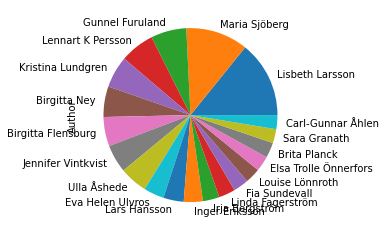

In [86]:
plotPublishedAuthor =   dfSKBLAuthorcsv  
  
plotPublishedAuthor["Author"] = plotPublishedAuthor["article_author_firstname"] + " " + plotPublishedAuthor["article_author_lastname"]   
plotAuthor = plotPublishedAuthor["Author"].value_counts()[:20]
plotAuthor.plot( kind = 'pie') 
plt.show()

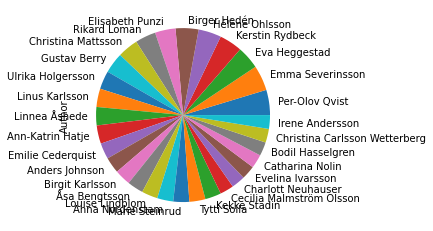

In [88]:
plotAuthor = plotPublishedAuthor["Author"].value_counts()[20:50]
plotAuthor.plot( kind = 'pie') 
plt.show()

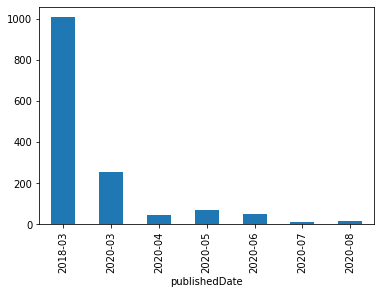

In [93]:
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby(df['last_payout'].dt.to_period('M')).sum().plot(kind='bar')
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby([dfSKBLAuthorcsv.publishedDate.year,dfSKBLAuthorcsv.publishedDate.month].agg('count'))
plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby(dfSKBLAuthorcsv.publishedDate.dt.to_period("M")).agg('count')
plotPublishedperMonth.plot( kind = 'bar') 
plt.show()

In [55]:
pd.set_option('display.max_rows', None) 
# Sort latest first 
dfSKBLAuthorcsv.sort_values(by=['publishedDate'], ascending=[False])

,skblid,wid,publishedDate,article_author_firstname,article_author_lastname,subtitle_sv,subtitle_eng,name_lastname,name_firstname
1410,SigridSynnergren,Q42304357,2020-08-30,Marie,Andersson,"Textilkonstnär, kyrkokonstnär, rektor","Textile artist, church artist, school principal",Synnergren,/Sigrid/ Birgitta
1413,BengtaEskilsson,Q97483170,2020-08-29,Birgitta,Calagos,"Textilkonstnär, vävlärare","Textile artist, weaving teacher",Eskilsson,/Bengta/
1409,EsterGill,Q25929722,2020-08-29,Lena Adamina,Waldau,"Konstnär, serietecknare","Artist, cartoonist",Gill,/Ester/ Johanna
1408,IdaAmaliavonPlomgren,Q23989215,2020-08-29,Camilla,Bergvall,"Fäktare, kvinnosakskvinna, skribent","Fencer, proponent of women&apos;s issues, writer",von Plomgren,/Ida/ Amalia
1403,HildaAugustaTonning,Q4989911,2020-08-29,Jane,Betts,"Rösträttskvinna, lärare","Suffragette, teacher",Tonning,Hilda /Augusta/
1459,IngridGamstorp0,Q98718027,2020-08-28,Bo,Strömberg,"Läkare, professor","Doctor, professor",Gamstorp,/Ingrid/
1401,MartaLindqvist,Q4962906,2020-08-27,Birgitta,Ney,"Journalist, översättare, författare","Journalist, translator, author",Lindqvist,/Märta/
1402,LouiseMichaeli,Q4967178,2020-08-27,Dan,Olsson,Operasångare,Opera singer,Michaëli,Lovisa (/Louise/) Charlotta Helena
1458,AlmaAndersson,Q98684599,2020-08-26,Mats,Larsson,"Baptist, predikant, pionjär",Pioneering Baptist preacher,Andersson,/Alma/
1457,IngerAdaminaWaldau0,Q98534043,2020-08-20,Lena Adamina,Waldau,"Banktjänsteman, pionjär",Pioneering bank clerk,Waldau,/Inger/ Adamina
